In [1]:
import pyspark
from pyspark.sql import SparkSession

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import casual

!spark-shell --version

# Create SparkSession
spark = SparkSession.builder.master("local[*]") \
                    .appName('BTC_Project') \
                    .getOrCreate()

print(f'The PySpark {spark.version} version is running...')

24/03/21 20:56:00 WARN Utils: Your hostname, Prasads-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 134.154.61.30 instead (on interface en0)
24/03/21 20:56:00 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 3.5.1
      /_/
                        
Using Scala version 2.12.18, OpenJDK 64-Bit Server VM, 21.0.2
Branch HEAD
Compiled by user heartsavior on 2024-02-15T11:24:58Z
Revision fd86f85e181fc2dc0f50a096855acf83a6cc5d9c
Url https://github.com/apache/spark
Type --help for more information.
The PySpark 3.5.1 version is running...


In [2]:
import pandas as pd
import numpy as np

import pyspark.sql.functions as F
import matplotlib.pyplot as plt


In [3]:
tweets_df = spark.read.csv('tweets.csv', sep=";",inferSchema=True, header=True,multiLine=True)

In [4]:
tweets_df.printSchema()

root
 |-- id: string (nullable = true)
 |-- user: string (nullable = true)
 |-- fullname: string (nullable = true)
 |-- url: string (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- replies: string (nullable = true)
 |-- likes: string (nullable = true)
 |-- retweets: string (nullable = true)
 |-- text: string (nullable = true)



In [5]:
tweets_df.show()

+-------------------+---------------+------------------------+----+--------------------+-------+-----+--------+-------------------------------------+
|                 id|           user|                fullname| url|           timestamp|replies|likes|retweets|                                 text|
+-------------------+---------------+------------------------+----+--------------------+-------+-----+--------+-------------------------------------+
|1132977055300300800|   KamdemAbdiel|           Abdiel kamdem|NULL|2019-05-27 11:49:...|      0|    0|       0|                 È appena uscito u...|
|1132977073402736640|      bitcointe|               Bitcointe|NULL|2019-05-27 11:49:...|      0|    0|       0|                 Cardano: Digitize...|
|1132977023893139456|      3eyedbran|     Bran - 3 Eyed Raven|NULL|2019-05-27 11:49:...|      0|    2|       1|                 Another Test twee...|
|1132977089089556481|  DetroitCrypto|             J. Scardina|NULL|2019-05-27 11:49:...|      0|    

In [6]:
tweets_df = tweets_df.withColumn('timestamp', tweets_df['timestamp'].cast('timestamp'))
tweets_df = tweets_df.withColumn('id', tweets_df['id'].cast('long'))
tweets_df = tweets_df.withColumn('likes', tweets_df['likes'].cast('int'))
tweets_df = tweets_df.withColumn('retweets', tweets_df['retweets'].cast('int'))
tweets_df = tweets_df.withColumn('replies', tweets_df['replies'].cast('int'))
tweets_df = tweets_df.filter(tweets_df.text. isNotNull())
tweets_df = tweets_df.withColumnRenamed("text", "tweet")
tweets_df = tweets_df.withColumnRenamed("timestamp", "time_posted")


In [7]:
tweets_df = tweets_df.drop('url')

In [8]:
tweets_df = tweets_df.withColumn('month', F.date_format('time_posted', 'MM'))
tweets_df = tweets_df.withColumn('year', F.date_format('time_posted', 'YYYY'))

tweets_df = tweets_df.withColumn('month', tweets_df['month'].cast('int'))
tweets_df = tweets_df.withColumn('year', tweets_df['year'].cast('int'))

In [9]:
tweets_df.dtypes

[('id', 'bigint'),
 ('user', 'string'),
 ('fullname', 'string'),
 ('time_posted', 'timestamp'),
 ('replies', 'int'),
 ('likes', 'int'),
 ('retweets', 'int'),
 ('tweet', 'string'),
 ('month', 'int'),
 ('year', 'int')]

In [10]:
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")
tweets_df.show()

+-------------------+---------------+------------------------+-------------------+-------+-----+--------+-------------------------------------+-----+----+
|                 id|           user|                fullname|        time_posted|replies|likes|retweets|                                tweet|month|year|
+-------------------+---------------+------------------------+-------------------+-------+-----+--------+-------------------------------------+-----+----+
|1132977055300300800|   KamdemAbdiel|           Abdiel kamdem|2019-05-27 04:49:14|      0|    0|       0|                 È appena uscito u...|    5|2019|
|1132977073402736640|      bitcointe|               Bitcointe|2019-05-27 04:49:18|      0|    0|       0|                 Cardano: Digitize...|    5|2019|
|1132977023893139456|      3eyedbran|     Bran - 3 Eyed Raven|2019-05-27 04:49:06|      0|    2|       1|                 Another Test twee...|    5|2019|
|1132977089089556481|  DetroitCrypto|             J. Scardina|2019-05-

In [11]:
user_activity = tweets_df.groupby('user').agg(
    F.count('id').alias('tweet_count'),
    F.sum('likes').alias('total_likes'),
    F.sum('retweets').alias('total_retweets')
)

In [12]:
user_activity_pd = user_activity.toPandas()

In [13]:
user_activity_pd.head(20)

,user,tweet_count,total_likes,total_retweets
0,Y_Speculation,318,60.0,34.0
1,Collegicoin,7,622.0,450.0
2,iam_furbie,2,0.0,0.0
3,AzamShaghaghi,36,182.0,43.0
4,d_mazurek524,6,1.0,1.0
5,CryptoBuyerSell,4130,26.0,61.0
6,thirdbrainfx,18634,294.0,461.0
7,quantadelic,134,89.0,36.0
8,goldbe,17,351.0,78.0
9,vex_hc,2,12.0,6.0


In [14]:
monthly_stats = tweets_df.groupBy('month') \
    .agg({'likes': 'sum', 'retweets': 'sum', 'tweet': 'count'}) \
    .withColumnRenamed('sum(likes)', 'total_likes') \
    .withColumnRenamed('sum(retweets)', 'total_retweets') \
    .withColumnRenamed('count(tweet)', 'tweet_count') \
    .orderBy('month') \
    .toPandas()

In [15]:
yearly_stats = tweets_df.groupBy('year') \
    .agg({'likes': 'sum', 'retweets': 'sum', 'tweet': 'count'}) \
    .withColumnRenamed('sum(likes)', 'total_likes') \
    .withColumnRenamed('sum(retweets)', 'total_retweets') \
    .withColumnRenamed('count(tweet)', 'tweet_count') \
    .orderBy('year') \
    .toPandas()

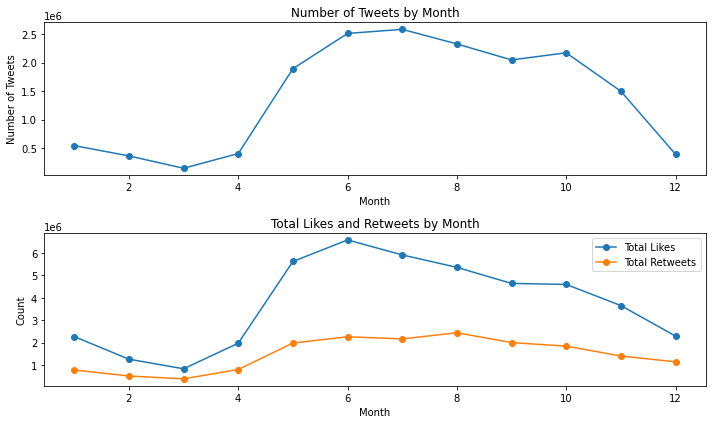

In [16]:
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(monthly_stats['month'], monthly_stats['tweet_count'], marker='o')
plt.title('Number of Tweets by Month')
plt.xlabel('Month')
plt.ylabel('Number of Tweets')

plt.subplot(2, 1, 2)
plt.plot(monthly_stats['month'], monthly_stats['total_likes'], marker='o', label='Total Likes')
plt.plot(monthly_stats['month'], monthly_stats['total_retweets'], marker='o', label='Total Retweets')
plt.title('Total Likes and Retweets by Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.legend()

plt.tight_layout()
plt.show()


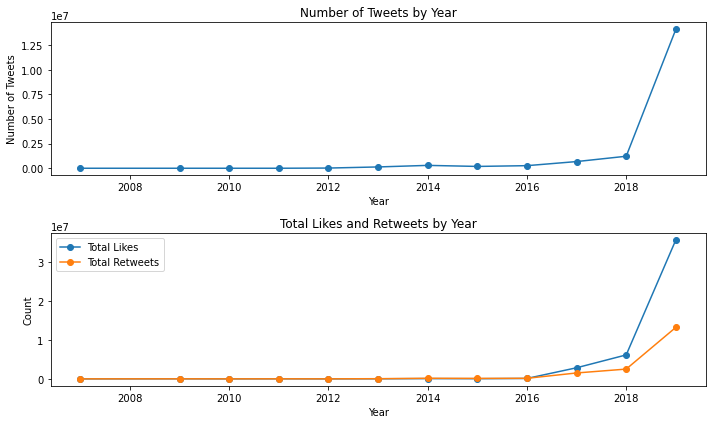

In [17]:
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(yearly_stats['year'], yearly_stats['tweet_count'], marker='o')
plt.title('Number of Tweets by Year')
plt.xlabel('Year')
plt.ylabel('Number of Tweets')

plt.subplot(2, 1, 2)
plt.plot(yearly_stats['year'], yearly_stats['total_likes'], marker='o', label='Total Likes')
plt.plot(yearly_stats['year'], yearly_stats['total_retweets'], marker='o', label='Total Retweets')
plt.title('Total Likes and Retweets by Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend()

plt.tight_layout()
plt.show()

In [18]:
btc_df = spark.read.csv('btc.csv',inferSchema=True, header=True,multiLine=True)

In [19]:
btc_df = btc_df.withColumn("Open", btc_df["Open"].cast("double"))
btc_df = btc_df.withColumn("High", btc_df["High"].cast("double"))
btc_df = btc_df.withColumn("Low", btc_df["Low"].cast("double"))
btc_df = btc_df.withColumn("Close", btc_df["Close"].cast("double"))
btc_df = btc_df.withColumn("Adj Close", btc_df["Adj Close"].cast("double"))
btc_df = btc_df.withColumn("Volume", btc_df["Volume"].cast("double"))

btc_df = btc_df.withColumn('month', F.date_format('Date', 'MM'))
btc_df = btc_df.withColumn('year', F.date_format('Date', 'YYYY'))

btc_df = btc_df.withColumn('month', btc_df['month'].cast('int'))
btc_df = btc_df.withColumn('year', btc_df['year'].cast('int'))

In [20]:
btc_df.describe().show()

+-------+----------+-----------------+------------------+-----------------+-----------------+-----------------+--------------------+------------------+------------------+
|summary|      Date|             Open|              High|              Low|            Close|        Adj Close|              Volume|             month|              year|
+-------+----------+-----------------+------------------+-----------------+-----------------+-----------------+--------------------+------------------+------------------+
|  count|      2353|             2349|              2349|             2349|             2349|             2349|                2349|              2353|              2353|
|   mean|      NULL|5721.921570233709|5883.1010306900625|5556.000000211149|5741.127479661974|5741.127479661974|1.052634439942401E10| 6.592860178495537|2017.4330641733957|
| stddev|      NULL|7156.218635002582| 7420.178133978874|6874.922194712393|7205.304191850392|7205.304191850392|1.595111600848704...|3.54105897453

In [21]:
monthly_avg_close = btc_df.groupBy("year", "month").agg(F.avg("Close").alias("avg_close")).orderBy("year", "month")

In [22]:
monthly_avg_close_pd = monthly_avg_close.toPandas()

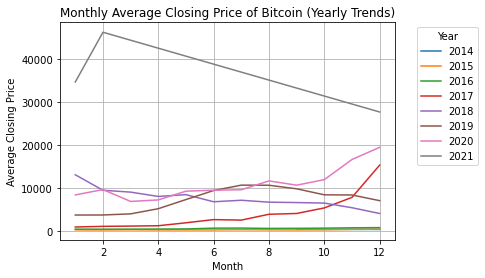

In [23]:
years = monthly_avg_close_pd["year"].unique()
for year in years:
    data_year = monthly_avg_close_pd[monthly_avg_close_pd["year"] == year]
    plt.plot(data_year["month"], data_year["avg_close"], label=str(year))

plt.xlabel("Month")
plt.ylabel("Average Closing Price")
plt.title("Monthly Average Closing Price of Bitcoin (Yearly Trends)")
plt.legend(title="Year", bbox_to_anchor=(1.05, 1), loc='upper left')  # Place legend outside the plot
plt.grid(True)
plt.show()

In [24]:
import nltk
from pyspark.sql.functions import udf
from nltk.sentiment import SentimentIntensityAnalyzer
import pyspark.sql.types as Types

nltk.download('vader_lexicon')
nltk.download('punkt')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/prasadpilankar/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/prasadpilankar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [25]:
tweets_df.printSchema()

root
 |-- id: long (nullable = true)
 |-- user: string (nullable = true)
 |-- fullname: string (nullable = true)
 |-- time_posted: timestamp (nullable = true)
 |-- replies: integer (nullable = true)
 |-- likes: integer (nullable = true)
 |-- retweets: integer (nullable = true)
 |-- tweet: string (nullable = true)
 |-- month: integer (nullable = true)
 |-- year: integer (nullable = true)



#### Preprocess

In [26]:
import re
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

# Define function to clean the text
def cleantxt(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)  # Remove mentions
    text = re.sub(r'#', '', text)  # Remove hashtags
    text = re.sub(r'RT[\s]+', '', text)  # Remove retweets
    text = re.sub(r'https?://\S+', '', text)  # Remove URLs
    text = re.sub(r':+', '', text)  # Remove colons
    text = re.sub(r'--+','', text)  # Remove dashes
    return text

# Register UDF
clean_udf = udf(cleantxt, StringType())

# Apply UDF to DataFrame
tweets_df = tweets_df.withColumn('cleaned_tweet', clean_udf(tweets_df['tweet']))

# Show the result
tweets_df.show(truncate=False)



+-------------------+---------------+------------------------+-------------------+-------+-----+--------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+----+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|id                 |user           |fullname                |time_posted        |replies|likes|retweets|tweet                                                                                                                                                                                              

In [27]:
# tweets_df = tweets_df.drop('sentiment_score')
# tweets_df = tweets_df.drop('cleaned_tweet')
# tweets_df = tweets_df.drop('subjectivity')
# tweets_df = tweets_df.drop('polarity')
# tweets_df = tweets_df.drop('tokenized_tweet')

In [28]:
from textblob import TextBlob
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType

# Define UDFs for subjectivity and polarity
def get_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def get_polarity(text):
    return TextBlob(text).sentiment.polarity

# Register UDFs
subjectivity_udf = udf(get_subjectivity, FloatType())
polarity_udf = udf(get_polarity, FloatType())

# Apply UDFs to DataFrame columns
tweets_df = tweets_df.withColumn("subjectivity", subjectivity_udf(F.col('cleaned_tweet')))
tweets_df = tweets_df.withColumn("polarity", polarity_udf(F.col('cleaned_tweet')))

# Show the result
tweets_df.show()


+-------------------+---------------+------------------------+-------------------+-------+-----+--------+-------------------------------------+-----+----+-------------------------------------+------------+------------+
|                 id|           user|                fullname|        time_posted|replies|likes|retweets|                                tweet|month|year|                        cleaned_tweet|subjectivity|    polarity|
+-------------------+---------------+------------------------+-------------------+-------+-----+--------+-------------------------------------+-----+----+-------------------------------------+------------+------------+
|1132977055300300800|   KamdemAbdiel|           Abdiel kamdem|2019-05-27 04:49:14|      0|    0|       0|                 È appena uscito u...|    5|2019|                 È appena uscito u...|         0.0|         0.0|
|1132977073402736640|      bitcointe|               Bitcointe|2019-05-27 04:49:18|      0|    0|       0|                 Ca

#### Tokenize

In [29]:
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType
from nltk.tokenize import word_tokenize

# Define function to tokenize the tweets
def tokenize_tweet(tweet):
    tokens = word_tokenize(tweet)
    return tokens

# Register UDF
tokenize_udf = udf(tokenize_tweet, ArrayType(StringType()))

# Apply UDF to DataFrame
tweets_df = tweets_df.withColumn('tokenized_tweet', tokenize_udf(F.col('tweet')))

# Show the result
tweets_df.show(truncate=False)

+-------------------+---------------+------------------------+-------------------+-------+-----+--------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+----+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------+------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [30]:
sia = SentimentIntensityAnalyzer()
def get_sentiment(tweet):
    sentiment_score = sia.polarity_scores(tweet)['compound']
    return sentiment_score

sentiment_udf = udf(get_sentiment, Types.ArrayType(Types.DoubleType()))
tweets_df = tweets_df.withColumn('sentiment_score', sentiment_udf(tweets_df['tweet']))

In [31]:
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Initialize the SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Define function to get sentiment score
def get_sentiment(tweet):
    sentiment_score = sia.polarity_scores(tweet)['compound']
    return sentiment_score

# Register UDF
sentiment_udf = udf(get_sentiment, DoubleType())

# Apply UDF to DataFrame
tweets_df = tweets_df.withColumn('sentiment_score', sentiment_udf(tweets_df['tweet']))

# Show the result
tweets_df.show()


+-------------------+---------------+------------------------+-------------------+-------+-----+--------+-------------------------------------+-----+----+-------------------------------------+------------+------------+------------------------------------+---------------+
|                 id|           user|                fullname|        time_posted|replies|likes|retweets|                                tweet|month|year|                        cleaned_tweet|subjectivity|    polarity|                     tokenized_tweet|sentiment_score|
+-------------------+---------------+------------------------+-------------------+-------+-----+--------+-------------------------------------+-----+----+-------------------------------------+------------+------------+------------------------------------+---------------+
|1132977055300300800|   KamdemAbdiel|           Abdiel kamdem|2019-05-27 04:49:14|      0|    0|       0|                 È appena uscito u...|    5|2019|                 È appena usci

In [32]:
tweets_df.printSchema()

root
 |-- id: long (nullable = true)
 |-- user: string (nullable = true)
 |-- fullname: string (nullable = true)
 |-- time_posted: timestamp (nullable = true)
 |-- replies: integer (nullable = true)
 |-- likes: integer (nullable = true)
 |-- retweets: integer (nullable = true)
 |-- tweet: string (nullable = true)
 |-- month: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- cleaned_tweet: string (nullable = true)
 |-- subjectivity: float (nullable = true)
 |-- polarity: float (nullable = true)
 |-- tokenized_tweet: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- sentiment_score: double (nullable = true)



In [33]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

# Define function to classify sentiment
def classify_sentiment(score):
    if score > 0.05:
        return 'Positive'
    elif score < -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Register UDF
classify_sentiment_udf = udf(classify_sentiment, StringType())

# Apply UDF to DataFrame
tweets_df = tweets_df.withColumn('sentiment_class', classify_sentiment_udf(tweets_df['sentiment_score']))

# Show the result
tweets_df.show()


+-------------------+---------------+------------------------+-------------------+-------+-----+--------+-------------------------------------+-----+----+-------------------------------------+------------+------------+------------------------------------+---------------+---------------+
|                 id|           user|                fullname|        time_posted|replies|likes|retweets|                                tweet|month|year|                        cleaned_tweet|subjectivity|    polarity|                     tokenized_tweet|sentiment_score|sentiment_class|
+-------------------+---------------+------------------------+-------------------+-------+-----+--------+-------------------------------------+-----+----+-------------------------------------+------------+------------+------------------------------------+---------------+---------------+
|1132977055300300800|   KamdemAbdiel|           Abdiel kamdem|2019-05-27 04:49:14|      0|    0|       0|                 È appena uscit

In [34]:
temp = tweets_df.groupby('sentiment_class').count().orderBy('count', ascending=False)

### Subjectivity Score: 
It represents the degree to which a piece of text expresses subjective information or opinions rather than factual information. Text with high subjectivity tends to express opinions, emotions, or personal experiences, while text with low subjectivity tends to convey factual information. The subjectivity score typically ranges from 0 to 1, where 0 indicates highly objective text and 1 indicates highly subjective text.

### Polarity Score: 
It measures the sentiment polarity of a piece of text, indicating whether the text expresses positive, negative, or neutral sentiment. The polarity score typically ranges from -1 to 1, where -1 indicates highly negative sentiment, 0 indicates neutral sentiment, and 1 indicates highly positive sentiment.

### Sensitivity Score: 
This score is less common in sentiment analysis compared to subjectivity and polarity scores. It can represent the sensitivity of the text to certain topics, keywords, or concepts. A high sensitivity score suggests that the text is highly responsive to specific topics or concepts, while a low sensitivity score suggests that the text is less responsive.

In [43]:
from pyspark.sql.functions import col

filtered_tweets_df = tweets_df.filter((col('likes') > 20) & (col('retweets') > 20) & (col('replies') > 0))
positive_negative_tweets_df = filtered_tweets_df.filter((col('sentiment_class') == 'Positive') | (col('sentiment_class') == 'Negative'))

# Show the result
positive_negative_tweets_df.show()


+-------------------+---------------+-------------------+-------------------+-------+-----+--------+--------------------+-----+----+--------------------+------------+-----------+--------------------+---------------+---------------+
|                 id|           user|           fullname|        time_posted|replies|likes|retweets|               tweet|month|year|       cleaned_tweet|subjectivity|   polarity|     tokenized_tweet|sentiment_score|sentiment_class|
+-------------------+---------------+-------------------+-------------------+-------+-----+--------+--------------------+-----+----+--------------------+------------+-----------+--------------------+---------------+---------------+
|1130878355375501313|giving_airdrops|     Daily_Airdrops|2019-05-21 09:49:45|     47|   81|      84|BTC IS STILL GOIN...|    5|2019|BTC IS STILL GOIN...|  0.78333336|  0.5989583|[BTC, IS, STILL, ...|          0.926|       Positive|
|1132927455985979393|giving_airdrops|     Daily_Airdrops|2019-05-27 01:3

In [44]:
positive_negative_tweets_df.count()

53918

In [45]:
# Split the DataFrame into train and validation sets (60% train, 40% validation)
train_df, validation_df = positive_negative_tweets_df.randomSplit([0.6, 0.4], seed=42)

# Show the result
train_df.show()

+------------------+---------------+--------------------+-------------------+-------+-----+--------+--------------------+-----+----+--------------------+------------+-----------+--------------------+---------------+---------------+
|                id|           user|            fullname|        time_posted|replies|likes|retweets|               tweet|month|year|       cleaned_tweet|subjectivity|   polarity|     tokenized_tweet|sentiment_score|sentiment_class|
+------------------+---------------+--------------------+-------------------+-------+-----+--------+--------------------+-----+----+--------------------+------------+-----------+--------------------+---------------+---------------+
|              NULL| cuttlefish_btc|   Crypto Cuttlefish|2016-10-21 13:44:49|      1|  131|      87|The Democratic Pa...|   10|2016|The Democratic Pa...|      0.0625|        0.0|[The, Democratic,...|         0.6597|       Positive|
|              NULL|stratisplatform|     Stratisplatform|2016-06-25 14:2

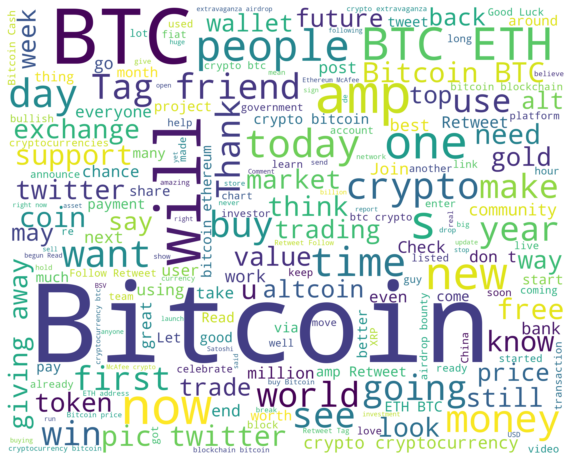

In [48]:
from wordcloud import WordCloud, STOPWORDS

# Collect the values of the "cleaned_tweet" column into a list
all_words_list = positive_negative_tweets_df.select("cleaned_tweet").rdd.flatMap(lambda x: x).collect()

# Join the words into a single string
all_words = ' '.join(all_words_list)

# Generate the word cloud
wordcloud = WordCloud(width=2500,
                      height=2000,
                      stopwords=STOPWORDS,
                      background_color="white",
                      random_state=21
                     ).generate(all_words)

# Display the word cloud
plt.figure(1, figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()